In [ ]:
'''
Project: NGuard
http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/MachineLearningCSV.zip
'''

**Download dataset**
- download the zip
- concatenate csv file as a single csv file
- convert csv into pandas dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


import pandas as pd
import numpy as np
import glob
import pathlib
import os
from joblib import dump,load

def extract_dataset():
  file_name = pathlib.Path("*.parquet")
  if not file_name.exists ():
    import zipfile
    with zipfile.ZipFile(os.getcwd()+"/drive/MyDrive/attackdataset.zip","r") as zip_ref:
      zip_ref.extractall()

  folder_path = os.getcwd() 
  return folder_path  


def read_as_dataframe(master_file):
  file_name = pathlib.Path("*.parquet")
  if not file_name.exists ():
    df = pd.concat(master_file,ignore_index=True)
    df.to_parquet('merged.parquet',index=False)
  else:  
    df = pd.read_parquet(file_name,engine='pyarrow')
  return df


**Testing**

In [ ]:
def test_performance(clf,x_test,y_actual,attack_name):
     
    from sklearn.metrics import f1_score,confusion_matrix,ConfusionMatrixDisplay
    from sklearn.metrics import precision_recall_curve, precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import average_precision_score
    
    y_predicted = clf.predict(x_test)
    score = f1_score(y_actual,y_predicted,average='micro')
    print('F1 Score: %.3f' % score)
    cmatrix = confusion_matrix(y_actual,y_predicted,labels=[1,0])
    cm_obj = ConfusionMatrixDisplay(cmatrix,display_labels=[1,0])
    cm_obj.plot()
    cm_obj.ax_.set(
                    title=f'{attack_name} Confusion Matrix', 
                    xlabel='Predicted Class', 
                    ylabel='True Class')



    print('Precison',precision_score(y_actual, y_predicted, average='macro'))
    print('Recall',recall_score(y_actual, y_predicted, average='macro'))
    print('Misclassification',(cmatrix[0][1]+cmatrix[1][0])/(cmatrix[0][0]+cmatrix[0][1]+cmatrix[1][0]+cmatrix[1][1]))
    print('Accuracy',(cmatrix[0][0]+cmatrix[1][1])/(cmatrix[0][0]+cmatrix[0][1]+cmatrix[1][0]+cmatrix[1][1]))
    print('FPR(A classicifed as B)',(cmatrix[1][0])/(cmatrix[1][0]+cmatrix[1][1]))
  

  

**Operations**

In [ ]:

dirpath = extract_dataset()

dos_data = pd.read_parquet(f'{dirpath}/dos.parquet',engine="pyarrow")
ddos_data = pd.read_parquet(f'{dirpath}/ddos.parquet',engine="pyarrow")
port_data =  pd.read_parquet(f'{dirpath}/portscan.parquet',engine="pyarrow")
patator_data =  pd.read_parquet(f'{dirpath}/patator.parquet',engine="pyarrow")
web_data = pd.read_parquet(f'{dirpath}/web.parquet',engine="pyarrow")

df = read_as_dataframe([dos_data,ddos_data,port_data,patator_data,web_data]).drop_duplicates()







In [ ]:
df.columns

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len',
       'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max',
       'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt',
       'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio',
       'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
       'Fwd Byts/b Avg', 'Fwd Pkt

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier





dos_data = dos_data[[ 'Bwd Pkts/s', 'Pkt Len Min', 'Bwd Pkt Len Std', 'FIN Flag Cnt',
                      'Fwd IAT Mean', 'Init Fwd Win Byts', 'Fwd Pkt Len Max', 'Fwd PSH Flags',
                      'SYN Flag Cnt', 'Fwd IAT Min', 'Init Bwd Win Byts', 'Flow IAT Min',
                      'Pkt Size Avg', 'Fwd Seg Size Min', 'Fwd Header Len','Label']]

port_data = port_data[['Subflow Fwd Byts','TotLen Fwd Pkts','Fwd Pkt Len Max','Pkt Size Avg','Label']]    

ddos_data = ddos_data[["Fwd Pkt Len Max","Subflow Fwd Byts","TotLen Fwd Pkts","Label"]]

patator_data = patator_data[["Init Fwd Win Byts", "Fwd Seg Size Min", "Pkt Len Std",
                             "Init Bwd Win Byts","Flow IAT Min","Pkt Size Avg","Label"]]

web_data = web_data[[ "Init Bwd Win Byts","Fwd Seg Size Min","Init Fwd Win Byts",
                      "Bwd Pkt Len Std","Fwd IAT Min","Label"]]
         


data = {
    'dos':dos_data,
    'portscan':port_data,
    'ddos':ddos_data,
    'patator':patator_data,
    'web':web_data
}


dos performance metrics
F1 Score: 0.999
Precison 0.9986379776281064
Recall 0.9987769660443513
Misclassification 0.0011982041374133227
Accuracy 0.9988017958625867
FPR(A classicifed as B) 0.0013148347661660913


portscan performance metrics
F1 Score: 0.997
Precison 0.9954265184752129
Recall 0.9966659491187735
Misclassification 0.003174867762299705
Accuracy 0.9968251322377003
FPR(A classicifed as B) 0.00369135258709285


ddos performance metrics
F1 Score: 0.999
Precison 0.9983616031202577
Recall 0.9985319175019235
Misclassification 0.0011206375546746155
Accuracy 0.9988793624453254
FPR(A classicifed as B) 0.002126274679973964


patator performance metrics
F1 Score: 1.000
Precison 0.9987263850323189
Recall 0.997873408411208
Misclassification 0.00020432623424258508
Accuracy 0.9997956737657574
FPR(A classicifed as B) 0.004176035978156119


web performance metrics
F1 Score: 0.999
Precison 0.9526614879324145
Recall 0.9877791626682875
Misclassification 0.0005980064836492438
Accuracy 0.9994019935

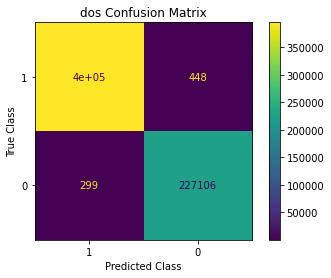

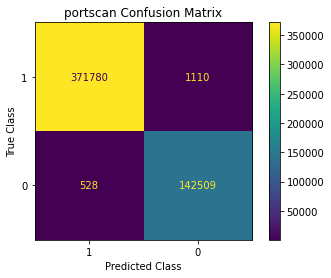

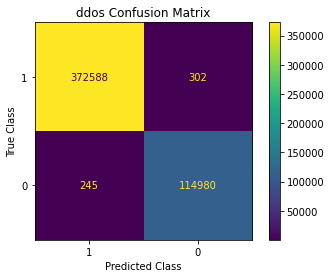

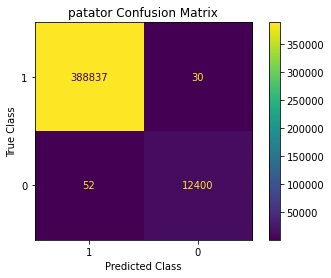

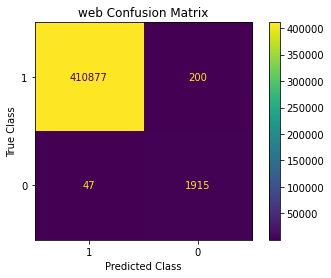

In [ ]:
for name,attack in data.items():

    X_train, X_test, Y_train, Y_test = train_test_split(attack.drop('Label', axis=1),
                                                        attack['Label'], stratify=attack['Label'],
                                                        train_size=0.10)

    sm = SMOTE()
    X,Y = sm.fit_resample(X_train.values,Y_train.values.astype('int'))

    clf = RandomForestClassifier(random_state=2,n_jobs=-1)
    clf.fit(X, Y)
    print(f'{name} performance metrics')
    test_performance(clf,
                    x_test=X_test.values,
                    y_actual=Y_test.values.astype('int'),
                    attack_name=name
                    )
    print('\n')
    dump(clf,f'{name}')

In [ ]:

# nmap = pd.read_csv('UDP_SCAN.pcap_Flow.csv')
# nmap = nmap.drop_duplicates(subset=['Flow ID'])
# nmap = nmap[['Subflow Fwd Byts','TotLen Fwd Pkts','Fwd Pkt Len Max','Pkt Size Avg']].values
# p = ports.predict(nmap)
# np.unique(p,return_counts=True)